<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Age-Gender-Identification/age_gen_prediction_keras_funtional_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [5]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jangedoo/utkface-new
!unzip -q utkface-new.zip

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 90% 298M/331M [00:00<00:00, 928MB/s] 
100% 331M/331M [00:00<00:00, 806MB/s]


# Imports

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pathlib

# Project Configuration

In [14]:
DATA_DIR = "/content/UTKFace"
IMAGE_SIZE = 64
BATCH_SIZE = 64
EPOCHS = 40
TRAIN_SPLIT = 0.8

image_paths = glob.glob(
    os.path.join(DATA_DIR, "*.jpg.chip.jpg"))

if not image_paths:
    image_paths = glob.glob(
        os.path.join(DATA_DIR, "*.jpg"))

print(f"Found {len(image_paths)} images.")

# Data Pipeline

In [8]:
def parse_filename(file_path):
    filename = tf.strings.split(file_path, os.sep)[-1]
    parts = tf.strings.split(filename, "_")
    # Extract age
    age = tf.strings.to_number(parts[0], out_type=tf.float32)
    # Extract gender
    gender = tf.strings.to_number(parts[1], out_type=tf.float32)

    return age, gender

def load_and_preprocess_image(file_path):
    # reading and decoding an image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    img /= 255.0
    # The previous `return img` was removed from here.

    # Extract labels
    age, gender = parse_filename(file_path)
    labels = {
        "age_output": age, "gender_output": gender
    }
    return img, labels

dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.shuffle(buffer_size=len(image_paths), seed=42)
# Map preprocess function
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Batching
train_size = int(len(image_paths) * TRAIN_SPLIT)
train_ds = dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = dataset.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Check few samples
for img, labels in train_ds.take(1):
    print("Input Shape:", img.shape)
    print("Labels Keys:", labels.keys())
    break

Input Shape: (64, 64, 64, 3)
Labels Keys: dict_keys(['age_output', 'gender_output'])


# Model Definition

In [15]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def build_model():
    input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_img")
    # Augment layer
    x = data_augmentation(input_layer)
    # Feature Extractor
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    x = layers.Flatten()(x)

    # Shared Dense Layer
    shared_dense = layers.Dense(256, activation="relu")(x)
    shared_dense = layers.Dropout(0.3)(shared_dense)

    # Branch 1
    # Gender -> this is classification
    gender_x = layers.Dense(128, activation="relu")(shared_dense)
    gender_x = layers.Dropout(0.3)(gender_x)
    gender_output = layers.Dense(1, activation="sigmoid",
                                 name="gender_output")(gender_x)

    # Branch 2
    # Age -> this is regression
    age_x = layers.Dense(128, activation="relu")(shared_dense)
    age_x = layers.Dropout(0.3)(age_x)
    age_output = layers.Dense(1, activation="linear",
                              name="age_output")(age_x)

    model = models.Model(inputs=input_layer,
                         outputs=[gender_output, age_output],
                         name="AgeGen_Net")
    return model

model = build_model()
model.summary()

Model: "AgeGen_Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │        896 │ input_img[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 4, 4, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4096)      │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  1,048,832 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]   

 Total params: 1,505,218 (5.74 MB)

 Trainable params: 1,504,258 (5.74 MB)

 Non-trainable params: 960 (3.75 KB)

## Plot

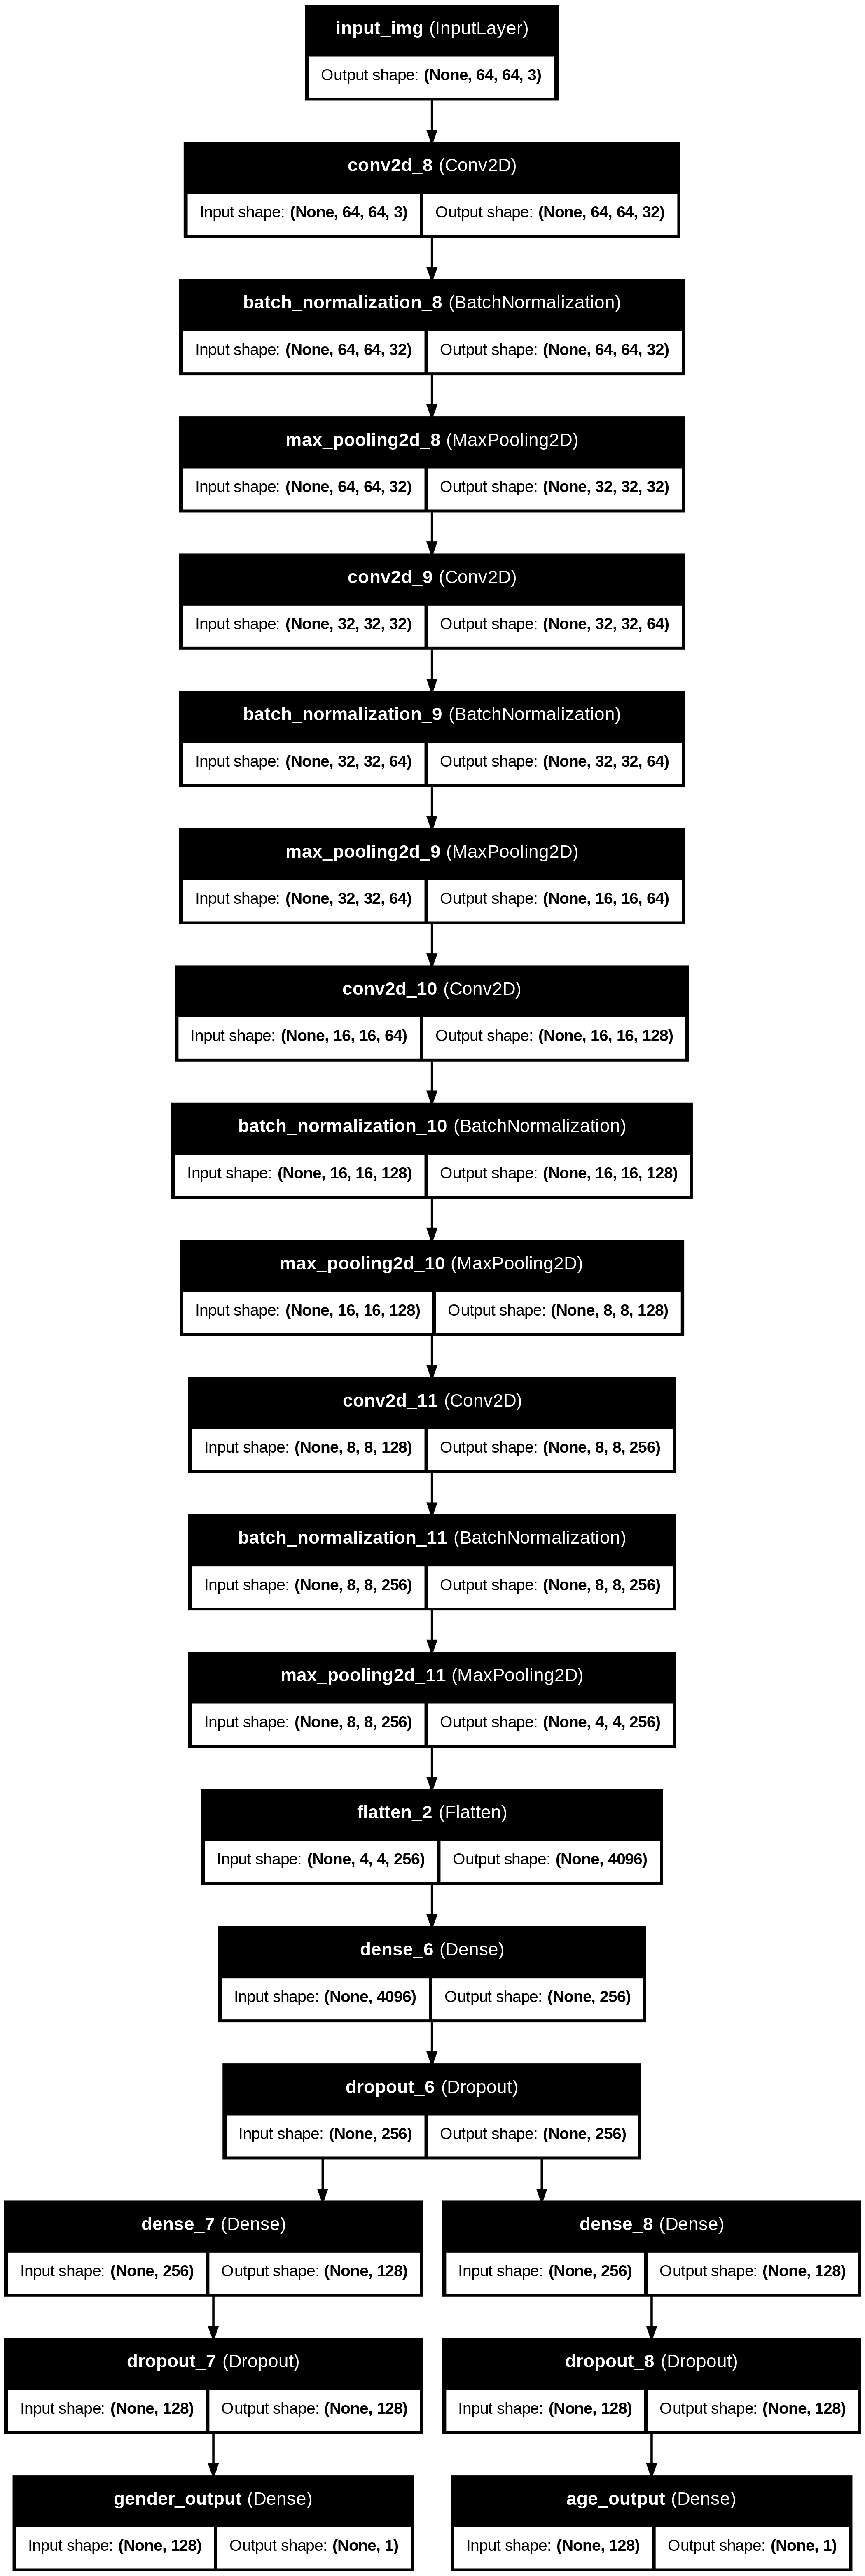

In [16]:
from keras.utils import plot_model
plot_model(model,
           show_shapes=True,
           show_layer_names=True,
           to_file='model.png')

# Compile & Training

In [17]:
model.compile(
    optimizer="adam",
    loss={
        "gender_output": "binary_crossentropy",
        "age_output": "mse"
    },
    loss_weights={
        "gender_output": 5.0,
        "age_output": 0.05
    },
    metrics={
        "gender_output": "accuracy",
        "age_output": "mae"
    }
)

# Define checkpoint
checkpoint = callbacks.ModelCheckpoint(
    "AgeGen_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/40
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - age_output_loss: 335.6792 - age_output_mae: 13.6159 - gender_output_accuracy: 0.6737 - gender_output_loss: 0.8297 - loss: 20.9326
Epoch 1: val_loss improved from inf to 24.58057, saving model to AgeGen_best.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - age_output_loss: 335.3571 - age_output_mae: 13.6088 - gender_output_accuracy: 0.6739 - gender_output_loss: 0.8290 - loss: 20.9128 - val_age_output_loss: 436.8331 - val_age_output_mae: 15.8089 - val_gender_output_accuracy: 0.8136 - val_gender_output_loss: 0.5113 - val_loss: 24.5806 - learning_rate: 0.0010
Epoch 2/40
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - age_output_loss: 150.9617 - age_output_mae: 9.1006 - gender_output_accuracy: 0.8320 - gender_output_loss: 0.3683 - loss: 9.3895
Epoch 2: val_loss improved from 24.58057 to 10.20243, saving model to AgeGen_best.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - age_output_loss: 150.8937 - age_output_mae: 9.0982 - gender_outpu

# Evaluation

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 


/tmp/ipython-input-3701243128.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"Pred: {int(pred_ages[i])}y, {p_gen}")


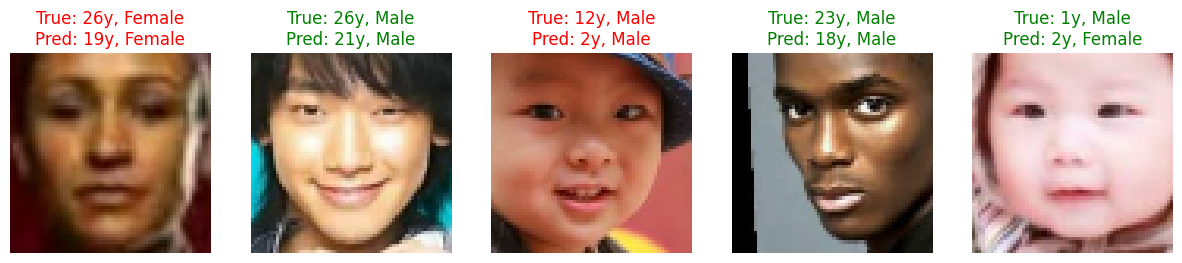

In [18]:
def visualize_results(model, dataset, num_samples=5):
    plt.figure(figsize=(15, 10))

    for images, labels in dataset.take(1):
        preds = model.predict(images)
        pred_genders = preds[0]
        pred_ages = preds[1]

        true_ages = labels['age_output']
        true_genders = labels['gender_output']

        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i])

            p_gen = "Female" if pred_genders[i] > 0.5 else "Male"
            t_gen = "Female" if true_genders[i] > 0.5 else "Male"

            title = (f"True: {int(true_ages[i])}y, {t_gen}\n"
                     f"Pred: {int(pred_ages[i])}y, {p_gen}")

            plt.title(title, color='green' if abs(true_ages[i] - pred_ages[i]) < 5 else 'red')
            plt.axis("off")
    plt.show()

visualize_results(model, val_ds)

# Inference

In [26]:
import cv2
from tensorflow.keras.utils import get_file

MODEL_PATH = "AgeGen_best.keras"
IMAGE_SIZE = 64  # Changed from 128 to 64 to match the model's expected input size

def load_inference_model():
    try:
        model = tf.keras.models.load_model(MODEL_PATH)
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Image preprocessing
def preprocess_image(image_path):
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    # Convert size
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    img = img / 255.0
    img_batch = tf.expand_dims(img, axis=0)
    return img_batch, img

# Final prediction
def predict_age_gender(model, image_path):
    input_img, display_img = preprocess_image(image_path)
    predictions = model.predict(input_img, verbose=0)
    gender_prob = predictions[0][0][0]
    age_value = int(predictions[1][0][0])

    gender_label = "Female" if gender_prob > 0.5 else "Male"
    confidence = gender_prob if gender_prob > 0.5 else 1 - gender_prob

    plt.figure(figsize=(6, 6))
    plt.imshow(display_img)
    plt.axis('off')

    title_text = (f"Pred Gender: {gender_label} ({confidence:.1%})\n"
                  f"Pred Age: {int(age_value)} years")

    plt.title(title_text, fontsize=14, color='blue', backgroundcolor='white')
    plt.show()

    print("-" * 30)
    print(f"   Raw Outputs:")
    print(f"   Gender Probability: {gender_prob:.4f}")
    print(f"   Predicted Age: {age_value:.2f}")
    print("-" * 30)